In [1]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt

In [2]:
match_url = "https://fbref.com/en/matches/7a3ab5da/Anderlecht-Gent-November-24-2024-Belgian-Pro-League"

# read the shots table (it has two header rows so ignore the first one)
shots_df = pd.read_html(match_url, attrs={"id": "shots_all"}, header=1)[0]

# drop the last 4 columns which we don't need
shots_df = shots_df.iloc[:, :-4]

# drop the empty row (shows half time)
shots_df = shots_df.dropna(subset = ["Player"])

# reset the index to avoid index issues in loops
shots_df = shots_df.reset_index(drop=True)

shots_df

,Minute,Player,Squad,xG,PSxG,Outcome,Distance,Body Part,Notes
0,1,Kasper Dolberg,Anderlecht,0.06,0.00,Blocked,13.0,Right Foot,NaN
1,1,Killian Sardella,Anderlecht,0.06,0.00,Off Target,23.0,Left Foot,NaN
2,15,Mario Stroeykens,Anderlecht,0.05,0.00,Blocked,18.0,Right Foot,NaN
3,21,Archie Brown,Gent,0.06,0.37,Saved,22.0,Right Foot,NaN
4,23,Mats Rits,Anderlecht,0.04,0.14,Goal,27.0,Right Foot,Deflected
5,25,Mathias Delorge,Gent,0.05,0.45,Saved,23.0,Left Foot,NaN
6,37,Omri Gandelman,Gent,0.02,0.00,Woodwork,14.0,Head,NaN
7,38,Samuel Edozie,Anderlecht,0.85,1.00,Goal,3.0,Left Foot,NaN
8,45+1,Kasper Dolberg,Anderlecht,0.11,0.48,Goal,22.0,Right Foot,"Free kick, Deflected"
9,51,Samuel Edozie,Anderlecht,0.04,0.64,Saved,25.0,Right Foot,NaN


In [6]:
# init lists
away_team = "Gent"
away_xg = [0]
away_minutes = [0]

home_team = "Anderlecht"
home_xg = [0]
home_minutes = [0]

# loop through df and add shots to correct lists
for row in range(len(shots_df)):
  minute_value = shots_df['Minute'][row]
    
  # shots in extra time will be added as 45 or 90 minute events
  if '+' in minute_value:
      minute_value = int(minute_value.split('+')[0])
  else:
      minute_value = int(minute_value)
      
  if shots_df['Squad'][row] == home_team:
    home_xg.append(shots_df['xG'][row])
    home_minutes.append(minute_value)
  
  if shots_df['Squad'][row] == away_team:
    away_xg.append(shots_df['xG'][row])
    away_minutes.append(minute_value)

# create cumulative lists
def create_cumulative_list(list: list):
  cumulative_list = []
  current_sum = 0

  for num in list:
    current_sum += num
    cumulative_list.append(current_sum)
  
  return cumulative_list

home_xg_cumulative = create_cumulative_list(home_xg)
home_total = home_xg_cumulative[-1]
away_xg_cumulative = create_cumulative_list(away_xg)
away_total = away_xg_cumulative[-1]

# add total as final 90 minute event
home_xg_cumulative.append(home_total)
home_minutes.append(90)
away_xg_cumulative.append(away_total)
away_minutes.append(90)

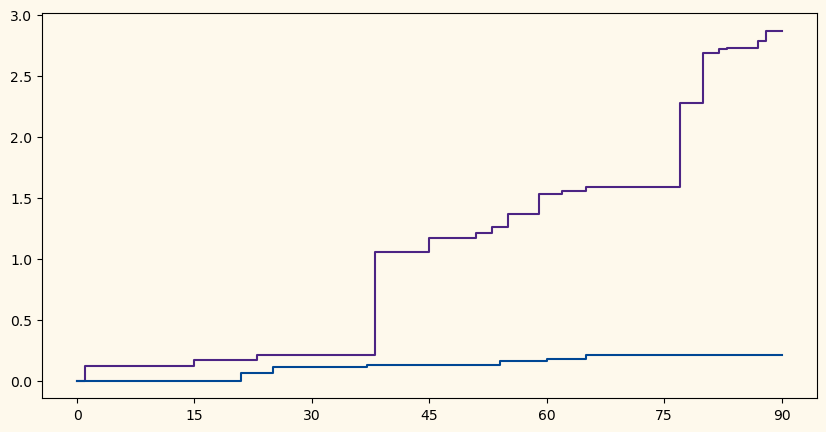

In [18]:
# init flowchart
fig, ax = plt.subplots(figsize = (10, 5))
fig.set_facecolor("#FEF9EC")
ax.set_facecolor("#FEF9EC")

# team colors
home_color = "#4c2484"
away_color = "#004794"

plt.xticks([0, 15, 30, 45, 60, 75, 90])

ax.step(x = home_minutes, y = home_xg_cumulative, where="post", color=home_color)
ax.step(x = away_minutes, y = away_xg_cumulative, where="post", color=away_color)